In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [4]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [5]:
draft2_path = '2 draft.csv'
draft6_path = '6 draft.csv'
train_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'

train  = pd.read_csv(train_path).rename(columns=clear_cols)
draft2 = pd.read_csv(draft2_path).rename(columns=clear_cols)
draft6 = pd.read_csv(draft6_path).rename(columns=clear_cols)

In [6]:
draft2.sample()

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
1157,PRV52446,129000.0,12900.0,0.0,0.0


In [7]:
draft6.sample()

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount
300,PRV51383,27.0,9.0,105.0,68.0


In [8]:
draft2Provider = draft2['Provider'].nunique()
print(f'Unique provider in draft2: {draft2Provider}, the shape is {draft2.shape}')
draft9Provider = draft6['Provider'].nunique()
print(f'Unique provider in draft9: {draft9Provider}, the shape is {draft6.shape}')


Unique provider in draft2: 5410, the shape is (5410, 5)
Unique provider in draft9: 5410, the shape is (5410, 5)


In [9]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    draft2,  # Left: Provider, IP_Claims_Total
    draft6,  # Right: Provider, OP_Claims_Total
    on='Provider',
    how='left'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [10]:
provider_claims

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount
0,PRV51001,97000.0,19400.000000,7640.0,382.000000,25.0,5.0,11.0,20.0
1,PRV51003,573000.0,9241.935484,32670.0,466.714286,320.0,62.0,165.0,70.0
2,PRV51004,0.0,0.000000,52170.0,350.134228,0.0,0.0,213.0,149.0
3,PRV51005,0.0,0.000000,280910.0,241.124464,0.0,0.0,1268.0,1165.0
4,PRV51007,19000.0,6333.333333,14710.0,213.188406,16.0,3.0,53.0,69.0
...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,10640.0,380.000000,0.0,0.0,60.0,28.0
5406,PRV57760,0.0,0.000000,4770.0,216.818182,0.0,0.0,7.0,22.0
5407,PRV57761,0.0,0.000000,18470.0,225.243902,0.0,0.0,114.0,82.0
5408,PRV57762,0.0,0.000000,1900.0,1900.000000,0.0,0.0,0.0,1.0


In [11]:
provider_claims = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
    )

In [12]:
provider_claims['PotentialFraud'] = provider_claims['PotentialFraud'].map({'Yes': 1, 'No': 0})


In [13]:
provider_claims.columns

Index(['Provider', 'IPTotalInscClaimAmtReimbursed',
       'IPMeanInscClaimAmtReimbursed', 'OPTotalInscClaimAmtReimbursed',
       'OPMeanInscClaimAmtReimbursed', 'IPClaimDurationSum',
       'IPClaimDurationCount', 'OPClaimDurationSum', 'OPClaimDurationCount',
       'PotentialFraud'],
      dtype='object')

In [16]:
X = provider_claims[['IPTotalInscClaimAmtReimbursed',
       'IPMeanInscClaimAmtReimbursed', 'OPTotalInscClaimAmtReimbursed',
       'OPMeanInscClaimAmtReimbursed', 'IPClaimDurationSum',
       'IPClaimDurationCount', 'OPClaimDurationSum', 'OPClaimDurationCount']]

In [17]:
y = provider_claims['PotentialFraud']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [19]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [20]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [21]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:,1]

In [22]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[964  13]
 [ 66  39]]


In [23]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.93
Precision: 0.75
Recall: 0.37
F1 Score: 0.50


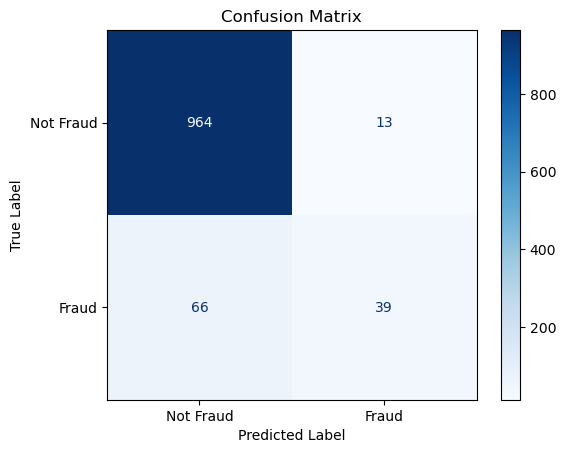

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

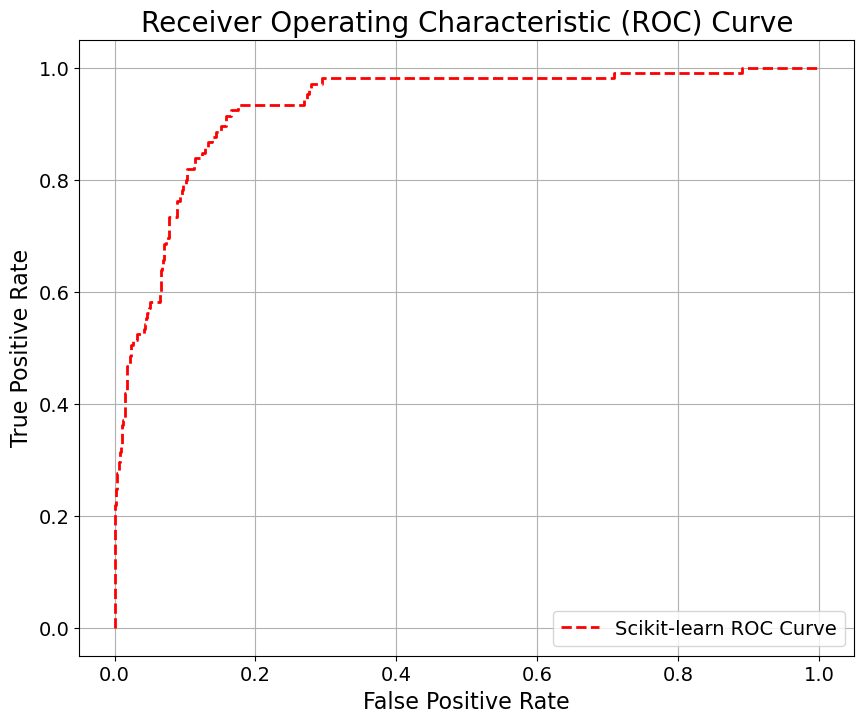

In [25]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [26]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9296875761563581)

In [27]:
# Create a DataFrame with predictions and actual values
roc_df = pd.DataFrame({
    'true_label': y_test.values,
    'pred_prob': y_proba # my guess?
})
roc_df.head(10)

,true_label,pred_prob
0,0,0.017483
1,0,0.014549
2,0,0.015144
3,0,0.037751
4,0,0.814381
5,0,0.066965
6,0,0.016575
7,1,0.993203
8,0,0.022498
9,0,0.029524


In [28]:
# Sort by predicted probability in descending order
roc_df = roc_df.sort_values('pred_prob', ascending=False).reset_index(drop=True)
# Display the first few rows to understand the data
print("Step 1: Sorted predictions by probability")
roc_df.head(10)

Step 1: Sorted predictions by probability


,true_label,pred_prob
0,1,1.000000
1,1,1.000000
2,1,1.000000
3,1,1.000000
4,1,0.999941
5,1,0.999931
6,1,0.999865
7,1,0.999185
8,1,0.999058
9,1,0.998870


In [29]:
# Step 2: Calculate TPR and FPR at each possible threshold
# Initialize columns for counts and rates
roc_df['threshold'] = roc_df['pred_prob']  # Each row's probability becomes a potential threshold
roc_df['TP'] = 0
roc_df['FP'] = 0
roc_df['FN'] = 0
roc_df['TN'] = 0
roc_df['TPR'] = 0.0
roc_df['FPR'] = 0.0

In [30]:
roc_df.head(10)

,true_label,pred_prob,threshold,TP,FP,FN,TN,TPR,FPR
0,1,1.000000,1.000000,0,0,0,0,0.0,0.0
1,1,1.000000,1.000000,0,0,0,0,0.0,0.0
2,1,1.000000,1.000000,0,0,0,0,0.0,0.0
3,1,1.000000,1.000000,0,0,0,0,0.0,0.0
4,1,0.999941,0.999941,0,0,0,0,0.0,0.0
5,1,0.999931,0.999931,0,0,0,0,0.0,0.0
6,1,0.999865,0.999865,0,0,0,0,0.0,0.0
7,1,0.999185,0.999185,0,0,0,0,0.0,0.0
8,1,0.999058,0.999058,0,0,0,0,0.0,0.0
9,1,0.998870,0.998870,0,0,0,0,0.0,0.0


In [31]:
# Calculate actual counts of positives and negatives
n_pos = sum(roc_df['true_label'] == 1)
n_neg = sum(roc_df['true_label'] == 0)
print(f"Total positive examples (fruad = fraud): {n_pos}")
print(f"Total negative examples: {n_neg}")

Total positive examples (fruad = fraud): 105
Total negative examples: 977


In [32]:
# Step 3: For each threshold (row in our sorted df), calculate confusion matrix values
for i in range(len(roc_df)):
    # At this threshold, predictions for indices >= i are positive
    # and predictions for indices < i are negative
    threshold = roc_df.loc[i, 'threshold']
    # Calculate TP, FP, FN, TN for this threshold
    preds = (roc_df['pred_prob'] >= threshold).astype(int)
    TP = sum((preds == 1) & (roc_df['true_label'] == 1))
    FP = sum((preds == 1) & (roc_df['true_label'] == 0))
    FN = sum((preds == 0) & (roc_df['true_label'] == 1))
    TN = sum((preds == 0) & (roc_df['true_label'] == 0))
    # Calculate TPR and FPR
    TPR = TP / n_pos if n_pos > 0 else 0
    FPR = FP / n_neg if n_neg > 0 else 0
    # Store values
    roc_df.loc[i, 'TP'] = TP
    roc_df.loc[i, 'FP'] = FP
    roc_df.loc[i, 'FN'] = FN
    roc_df.loc[i, 'TN'] = TN
    roc_df.loc[i, 'TPR'] = TPR
    roc_df.loc[i, 'FPR'] = FPR

In [33]:
roc_df

,true_label,pred_prob,threshold,TP,FP,FN,TN,TPR,FPR
0,1,1.000000,1.000000,1,0,104,977,0.009524,0.000000
1,1,1.000000,1.000000,2,0,103,977,0.019048,0.000000
2,1,1.000000,1.000000,3,0,102,977,0.028571,0.000000
3,1,1.000000,1.000000,4,0,101,977,0.038095,0.000000
4,1,0.999941,0.999941,5,0,100,977,0.047619,0.000000
...,...,...,...,...,...,...,...,...,...
1077,0,0.014086,0.014086,105,973,0,4,1.000000,0.995906
1078,0,0.014077,0.014077,105,975,0,2,1.000000,0.997953
1079,0,0.014077,0.014077,105,975,0,2,1.000000,0.997953
1080,0,0.014044,0.014044,105,977,0,0,1.000000,1.000000


In [34]:
# Step 4: Add the (0,0) point explicitly for plotting
roc_points = roc_df[['FPR', 'TPR']].copy()
roc_points.head(5)

,FPR,TPR
0,0.0,0.009524
1,0.0,0.019048
2,0.0,0.028571
3,0.0,0.038095
4,0.0,0.047619


In [35]:
# Add the (0,0) point - when threshold > max probability
roc_points.loc[-1] = [0, 0]
roc_points

,FPR,TPR
0,0.000000,0.009524
1,0.000000,0.019048
2,0.000000,0.028571
3,0.000000,0.038095
4,0.000000,0.047619
...,...,...
1078,0.997953,1.000000
1079,0.997953,1.000000
1080,1.000000,1.000000
1081,1.000000,1.000000


In [36]:
roc_points = roc_points.sort_index().reset_index(drop=True)
roc_points

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.009524
2,0.000000,0.019048
3,0.000000,0.028571
4,0.000000,0.038095
...,...,...
1078,0.995906,1.000000
1079,0.997953,1.000000
1080,0.997953,1.000000
1081,1.000000,1.000000


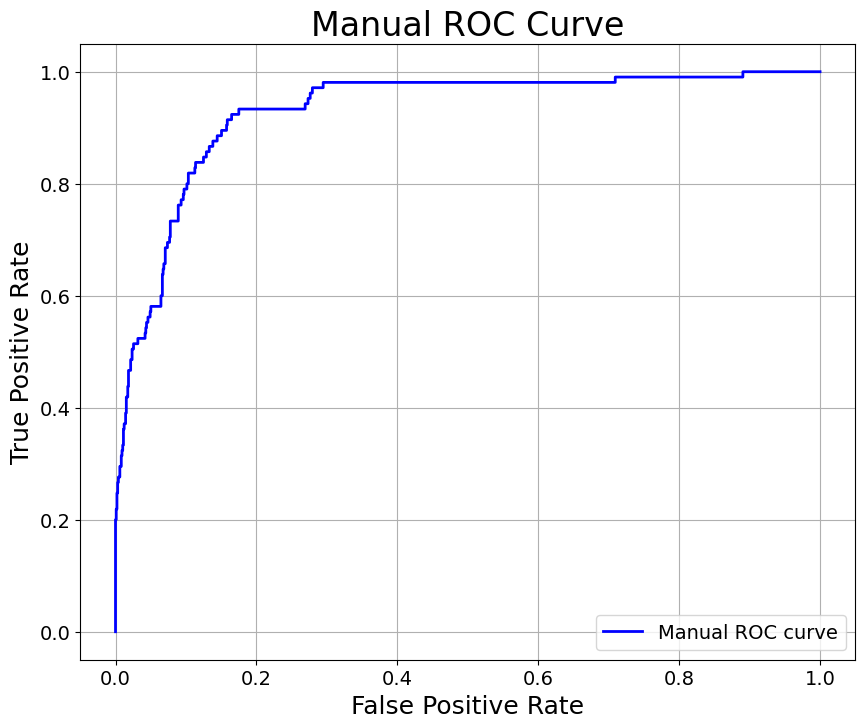

In [37]:
# Step 5: Plot the manually calculated ROC curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(roc_points['FPR'], roc_points['TPR'], 'b-', lw=2, label='Manual ROC curve')
# Set title with larger font size
ax.set_title('Manual ROC Curve', fontsize=24)
# Set axis labels with custom font sizes
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
# Set tick label sizes
ax.tick_params(axis='both', which='major', labelsize=14)
# Set legend font size
ax.legend(fontsize=14)
ax.grid(True)
plt.show()


### loooking for a better threshold to find better f1 score:

In [38]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

In [39]:
precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.12111821383780717


In [ ]:
# apply the new best threshold to the predicted probabilities
y_pred_custom = (y_proba >= best_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
print("After proccessing the best threshold for highest F1-score, \nHere is the Confusion Matrix:\n", cm)

Confusion Matrix:
 [[901  76]
 [ 28  77]]


In [41]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.90
Precision: 0.50
Recall: 0.73
F1 Score: 0.60


In [32]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc_score:.5f}")

ROC AUC Score: 0.91969


# Applying Cross Validation

In [43]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=1000, solver='lbfgs')  # Increase max_iter for convergence

# Perform 5-fold cross-validation
# Also looking for the best "ACCURACY"
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Cross-validation scores: [0.93253235 0.93438078 0.92698706 0.93345656 0.92883549]
Mean accuracy: 0.9312


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [44]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Perform GridSearchCV optimizing for recall
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and recall score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall Score: {grid_search.best_score_:.4f}")


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-pack

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Recall Score: 0.4539


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [45]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)

              precision    recall  f1-score   support

   Not Fraud       0.94      0.99      0.96       977
       Fraud       0.75      0.37      0.50       105

    accuracy                           0.93      1082
   macro avg       0.84      0.68      0.73      1082
weighted avg       0.92      0.93      0.92      1082



In [46]:
#  Grid search for best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall', n_jobs=-1)


In [47]:
from sklearn.metrics import make_scorer, fbeta_score
custom_scorer = make_scorer(fbeta_score, beta=2)


In [48]:
from sklearn.model_selection import GridSearchCV

# Define custom scorer (F-beta score with beta=2, which favors recall)
custom_scorer = make_scorer(fbeta_score, beta=2)

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
model = LogisticRegression(max_iter=1000)

# Use GridSearchCV with the custom scorer
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters & best F-beta score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F2 Score: {grid_search.best_score_:.4f}")


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-pack

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best F2 Score: 0.4940


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# I'm not sure what is F2 score. Need to check it

In [50]:
from imblearn.over_sampling import SMOTE

# Define features (X) and target (y)
X = provider_claims.drop(columns=['Provider','PotentialFraud'])
y = provider_claims['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [51]:
model_after_smote = LogisticRegression(max_iter=1000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [52]:
# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


## This time I'm checking for the best parameters for RECALL here:

In [53]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-pack

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [54]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9301


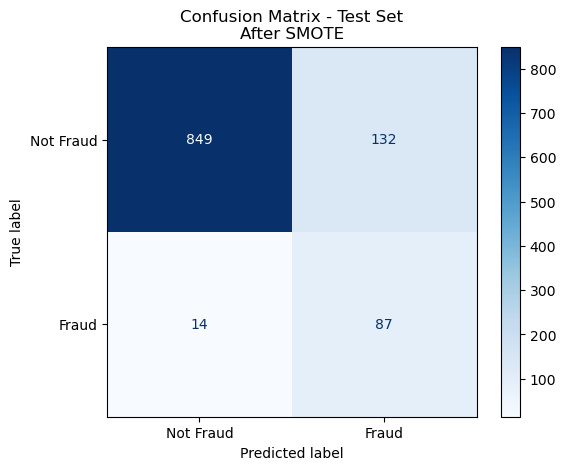

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set\nAfter SMOTE")
plt.show()


In [56]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\nAfter SMOTE:")
print(cm)

Confusion Matrix
After SMOTE:
[[849 132]
 [ 14  87]]


In [57]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('All scores after SMOTE:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

All scores after SMOTE:

Accuracy: 0.87
Precision: 0.40
Recall: 0.86
F1 Score: 0.54
